<a href="https://colab.research.google.com/github/AbderBouni/Satellite-Image-Deep-learning-using-U-net/blob/main/Copie_de_Satellite_Imagery_DeepLearning_ActivationHeatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code from Part 1 Exercise - Satellite Imagery Data Preparation



In [2]:
!pip install patchify

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [4]:
minmaxscaler = MinMaxScaler()

In [5]:
dataset_root_folder = '/content/drive/MyDrive/ColabNotebooks/'

In [6]:
dataset_name = "Semantic_segmentation_dataset/"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
image_patch_size = 256

In [9]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [10]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [11]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


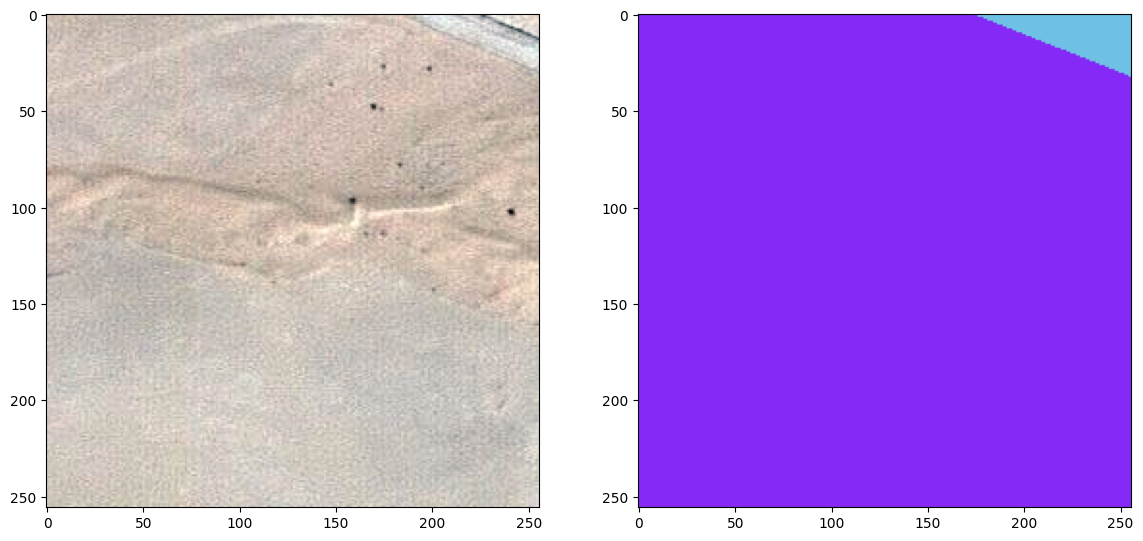

In [12]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [13]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [14]:
label = individual_patched_mask

In [15]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [16]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [17]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [18]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [19]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


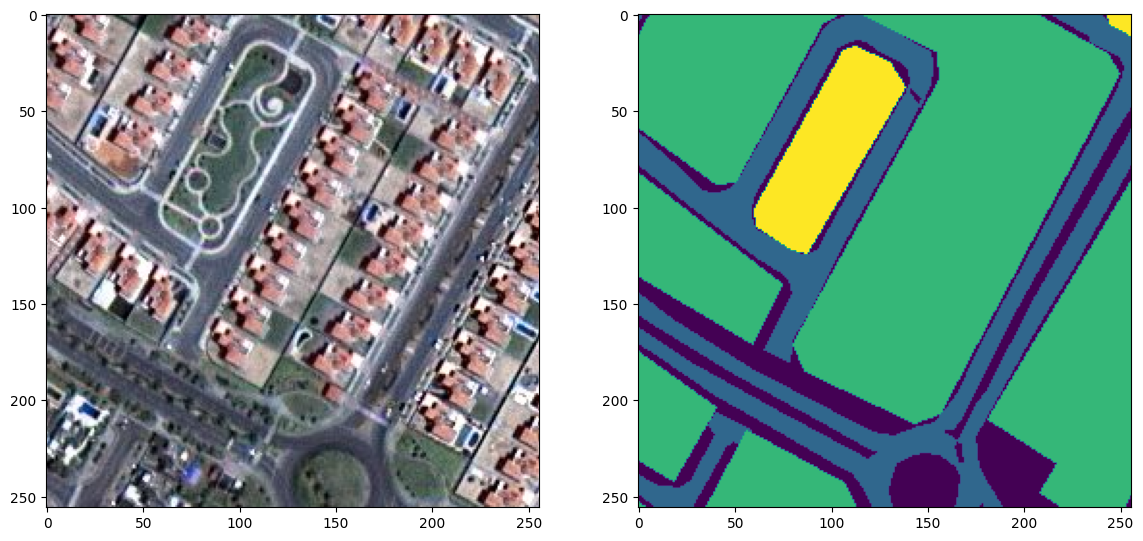

In [108]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [21]:
total_classes = len(np.unique(labels))

In [22]:
total_classes

6

In [23]:
from tensorflow.keras.utils import to_categorical

In [24]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [25]:
master_trianing_dataset = image_dataset

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [29]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [30]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Coding for Part 2: Deep Learning with Satellite Imagery Data

In [31]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [32]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [33]:
from keras import backend as K

In [34]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [35]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [36]:
metrics = ["accuracy", jaccard_coef]

In [37]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [38]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [39]:
model = get_deep_learning_model()

In [40]:
# Please uncomment this line to get model confiuration
# model.get_config()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [41]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [42]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [43]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [44]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [45]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [46]:
import tensorflow as tf

In [47]:
tf.keras.backend.clear_session()


In [48]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [50]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=40,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/40
51/51 [==============================] - 91s 2s/step - loss: 0.9982 - accuracy: 0.5717 - jaccard_coef: 0.2737 - val_loss: 0.9917 - val_accuracy: 0.6214 - val_jaccard_coef: 0.2982
Epoch 2/40
51/51 [==============================] - 84s 2s/step - loss: 0.9820 - accuracy: 0.6621 - jaccard_coef: 0.3523 - val_loss: 0.9791 - val_accuracy: 0.6640 - val_jaccard_coef: 0.4212
Epoch 3/40
51/51 [==============================] - 85s 2s/step - loss: 0.9691 - accuracy: 0.6925 - jaccard_coef: 0.4178 - val_loss: 0.9731 - val_accuracy: 0.6971 - val_jaccard_coef: 0.4268
Epoch 4/40
51/51 [==============================] - 83s 2s/step - loss: 0.9598 - accuracy: 0.7181 - jaccard_coef: 0.4746 - val_loss: 1.0219 - val_accuracy: 0.5824 - val_jaccard_coef: 0.3738
Epoch 5/40
51/51 [==============================] - 84s 2s/step - loss: 0.9546 - accuracy: 0.7370 - jaccard_coef: 0.4997 - val_loss: 0.9783 - val_accuracy: 0.6696 - val_jaccard_coef: 0.4466
Epoch 6/40
51/51 [==============================] 

In [51]:
history_a = model_history

In [52]:
history_a.history

{'loss': [0.998235821723938,
  0.9820011854171753,
  0.9691451191902161,
  0.9598444700241089,
  0.9545627236366272,
  0.9486451148986816,
  0.944761335849762,
  0.9417479634284973,
  0.939747154712677,
  0.9350025653839111,
  0.9299680590629578,
  0.927278995513916,
  0.9292387962341309,
  0.9270073771476746,
  0.9227669835090637,
  0.9218471050262451,
  0.9205189943313599,
  0.9207120537757874,
  0.9183257818222046,
  0.9170651435852051,
  0.91653972864151,
  0.915804386138916,
  0.9152237772941589,
  0.9138094186782837,
  0.9128846526145935,
  0.912483811378479,
  0.9108339548110962,
  0.9101701378822327,
  0.9088672399520874,
  0.9081165790557861,
  0.9086946249008179,
  0.9082806706428528,
  0.9068021774291992,
  0.9061629772186279,
  0.9052730798721313,
  0.9051656723022461,
  0.9038141965866089,
  0.9041723608970642,
  0.9042758345603943,
  0.9017284512519836],
 'accuracy': [0.5717288255691528,
  0.6620635390281677,
  0.6924983263015747,
  0.7180709838867188,
  0.73695307970047,

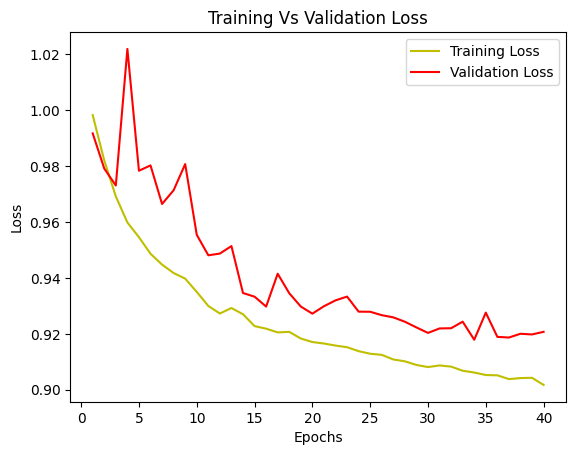

In [53]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

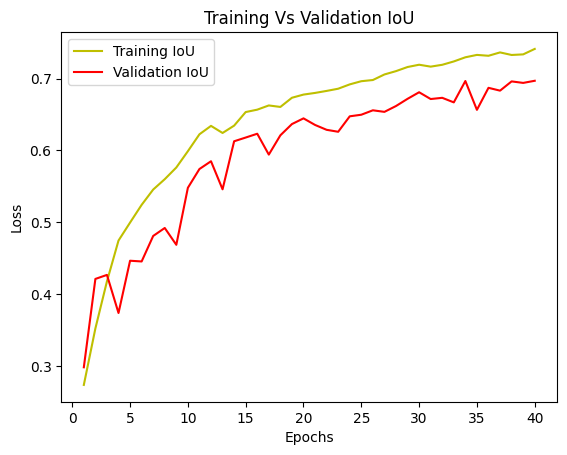

In [54]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [55]:
model_history.params

{'verbose': 1, 'epochs': 40, 'steps': 51}

In [56]:
y_pred = model.predict(X_test)

5/5 [==============================] - 2s 363ms/step


In [57]:
len(y_pred)

142

In [59]:
y_pred

array([[[[9.33378469e-03, 4.68493164e-01, 2.87629575e-01,
          1.43281668e-01, 8.14885497e-02, 9.77326743e-03],
         [9.04907181e-04, 5.54403782e-01, 2.68466204e-01,
          1.37769729e-01, 3.66937071e-02, 1.76171330e-03],
         [4.80361661e-04, 5.55925667e-01, 2.57895648e-01,
          1.39291048e-01, 4.53840643e-02, 1.02318358e-03],
         ...,
         [3.80766508e-03, 6.70150042e-01, 1.42801449e-01,
          7.58490339e-02, 1.06097162e-01, 1.29471533e-03],
         [5.98378759e-03, 5.83999157e-01, 1.53757557e-01,
          1.13968000e-01, 1.39261603e-01, 3.02990363e-03],
         [1.94485970e-02, 4.94154871e-01, 1.60067275e-01,
          1.46543935e-01, 1.65800482e-01, 1.39848795e-02]],

        [[1.01759285e-03, 5.59838414e-01, 2.32242614e-01,
          1.43720657e-01, 6.08711876e-02, 2.30950420e-03],
         [2.27998808e-05, 6.54973328e-01, 1.88906521e-01,
          1.42691359e-01, 1.32405302e-02, 1.65486752e-04],
         [1.29860146e-05, 6.09547615e-01, 2.5407

In [60]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [61]:
len(y_pred_argmax)

142

In [63]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 3, 1, 1],
        [2, 2, 2, ..., 3, 3, 3],
        [2, 2, 2, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [64]:
y_test_argmax = np.argmax(y_test, axis=3)

In [65]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# Model saving and reloading (with custom loss and custom metrics)

- loss
  - 'dice_loss_plus_1focal_loss': total_loss
- Metrics
  - jaccard_coef: jaccard_coef

In [68]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N

In [69]:
model.save('satellite-imagery.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Jul 16 17:48 .
drwxr-xr-x 1 root root 4.0K Jul 16 16:27 ..
drwxr-xr-x 4 root root 4.0K Jul 11 13:18 .config
drwx------ 5 root root 4.0K Jul 16 16:42 drive
drwxr-xr-x 1 root root 4.0K Jul 11 13:18 sample_data
-rw-r--r-- 1 root root  23M Jul 16 17:48 satellite-imagery.h5


In [71]:
from keras.models import load_model

In [72]:
saved_model = load_model('/content/satellite-imagery.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [73]:
saved_model.loss.name

'dice_loss_plus_1focal_loss'

In [74]:
saved_model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N

## Performing Prediction using the custom image from Google Map

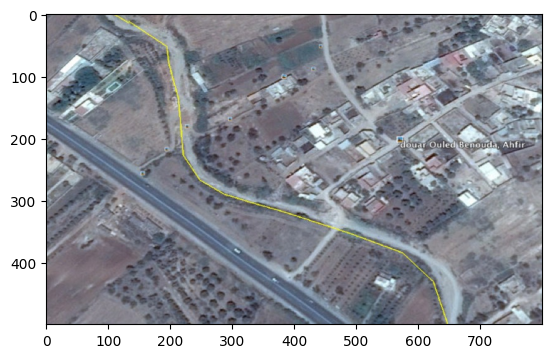

In [76]:
plt.imshow(Image.open('/content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/ImgTest.jpg'))

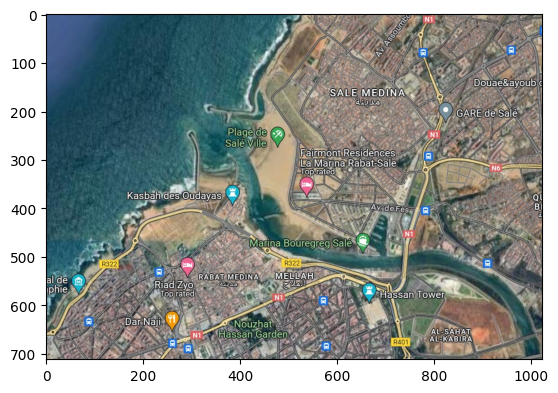

In [132]:
img_path='/content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/cap.jpg'
plt.imshow(Image.open(img_path))

In [133]:
image = Image.open(img_path)
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [134]:
prediction = saved_model.predict(image)

1/1 [==============================] - 0s 51ms/step


In [135]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

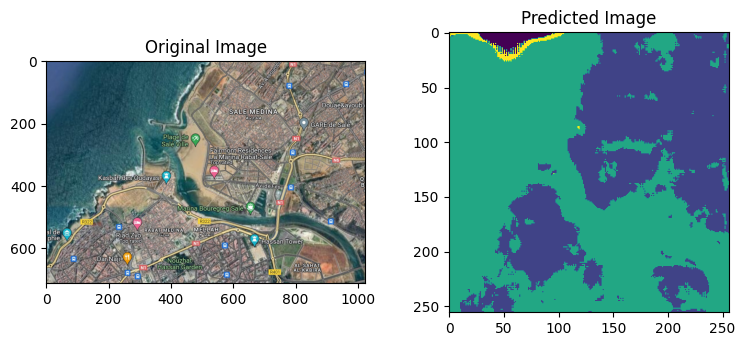

In [136]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open(img_path))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [137]:
import random

In [138]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = saved_model.predict(test_image_input)
#prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 260ms/step


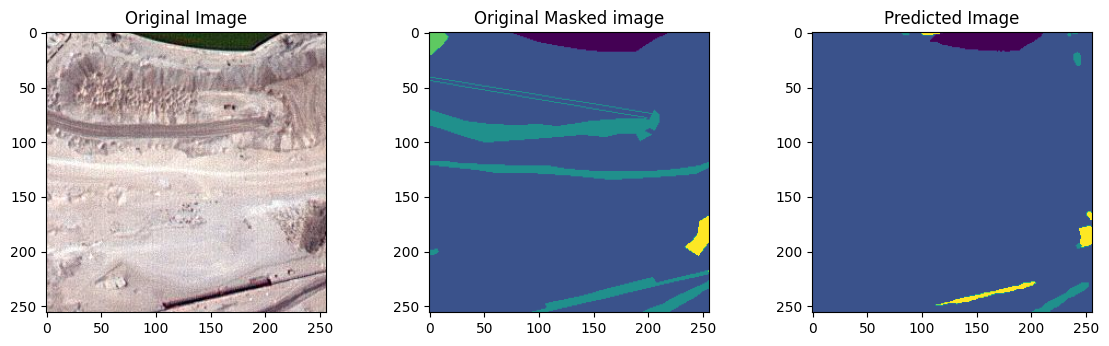

In [139]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


# Collecting Activation and gradients output from Keras Model

In [140]:
!pip install keract

In [141]:
import keract as ke

In [146]:
activations = ke.get_activations(saved_model, image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [148]:
activations

OrderedDict([('input_1',
              array([[[[ 73,  99, 150],
                       [ 72,  98, 149],
                       [ 71,  97, 148],
                       ...,
                       [139, 138, 123],
                       [138, 132, 114],
                       [132, 124, 103]],
              
                      [[ 73,  99, 150],
                       [ 72,  98, 149],
                       [ 71,  97, 148],
                       ...,
                       [128, 128, 112],
                       [130, 128, 110],
                       [124, 120, 100]],
              
                      [[ 72,  98, 147],
                       [ 71,  97, 146],
                       [ 70,  96, 145],
                       ...,
                       [103, 101,  98],
                       [ 99,  98,  93],
                       [ 98,  96,  90]],
              
                      ...,
              
                      [[151, 145, 131],
                       [157, 151, 139],
 

In [149]:
ls -lah /content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/activations

total 0


In [150]:
ke.display_activations(activations, cmap='viridis', save=True, directory='/content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

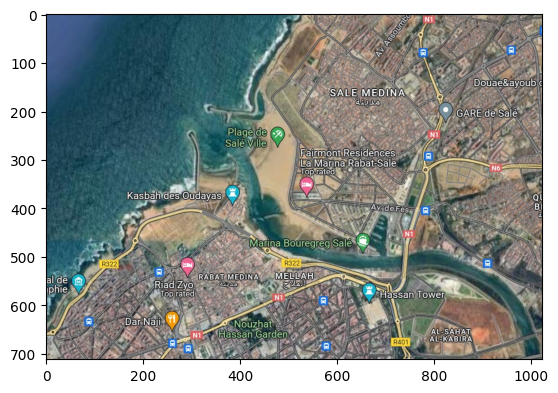

In [152]:
plt.imshow(Image.open(img_path))

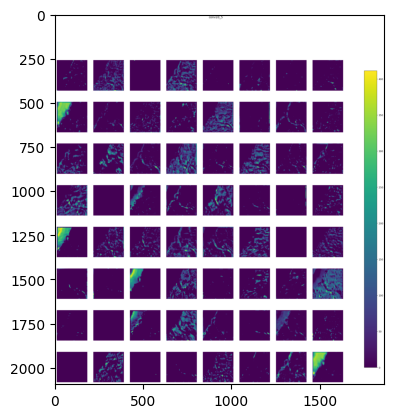

In [154]:
plt.imshow(Image.open('/content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/activations/11_conv2d_5.png'))

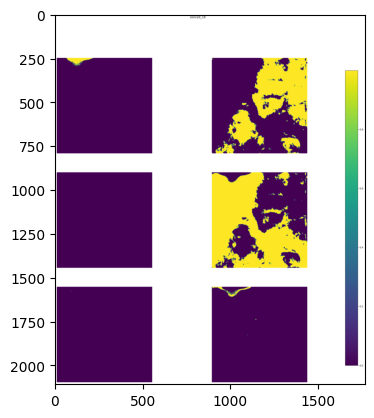

In [155]:
plt.imshow(Image.open('/content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/activations/40_conv2d_18.png'))

In [156]:
image = Image.open(img_path)
image = image.resize((256,256))
image_as_array = np.array(image)
image_as_array = image_as_array.astype(np.float32)
ke.display_heatmaps(activations, image_as_array, save=True, directory='/content/drive/MyDrive/ColabNotebooks/Semantic_segmentation_dataset/heatmap')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

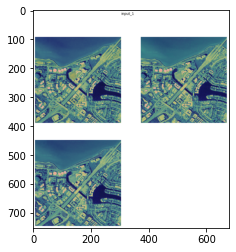

In [ ]:
plt.imshow(Image.open('/content/heatmap/0_input_1.png'))

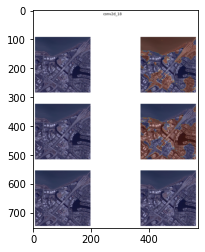

In [ ]:
plt.imshow(Image.open('/content/heatmap/40_conv2d_18.png'))

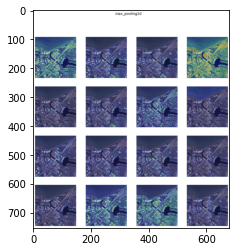

In [ ]:
plt.imshow(Image.open('/content/heatmap/4_max_pooling2d.png'))

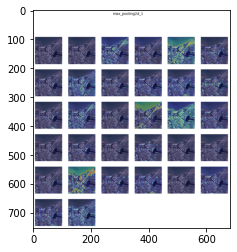

In [ ]:
plt.imshow(Image.open('/content/heatmap/8_max_pooling2d_1.png'))

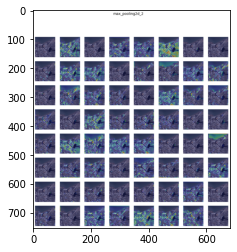

In [ ]:
plt.imshow(Image.open('/content/heatmap/12_max_pooling2d_2.png'))

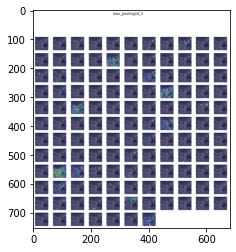

In [ ]:
plt.imshow(Image.open('/content/heatmap/16_max_pooling2d_3.png'))